In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sympy import symbols, lambdify

In [6]:
# 2nd order BVP (Boundary Value Problem) definition

def problem_definition():
    Pe = 4   # Peclet number
    Da = 5   # Damkohler number

    # 2nd order Ordinary Differential Equation generic form : a0*y'' + a1*y' + a2*f(y) = g(x)
    # Constant coefficients of the 2nd order ODE
    a0 = 1/Pe
    a1 = -1
    a2 = -Da

    # Symbolic expressions of f(y) and g(x) functions
    y_s = symbols('y_s')
    f_func = lambdify(y_s, y_s**2, modules='numpy')
    x_s = symbols('x_s')
    g_func = lambdify(x_s, ((x_s**0) - 1), modules='numpy')

    # Boundary conditions:
    # at x=0:  k1 * dy/dx + k2 * y = l1
    # at x=1:  k3 * dy/dx + k4 * y = l2
    k1, k2 = 1, -Pe
    k3, k4 = 1, 0
    l1, l2 = -Pe, 0

    return a0, a1, a2, k1, k2, k3, k4, l1, l2, f_func, g_func

a0, a1, a2, k1, k2, k3, k4, l1, l2, f_func, g_func = problem_definition()

In [7]:
# Orthogonal Collocation on Finite Element (OCFE) solver

def ocfe_solver(n_elem=2, poly_order=2, h=None):

    # Collocation points: shifted Legendre roots in (0,1)
    roots_dict = {
        2: np.array([0.21132, 0.78868]),
        3: np.array([0.1127, 0.5, 0.8873]),
        4: np.array([0.06943, 0.33001, 0.66999, 0.93057]),
    }
    if poly_order not in roots_dict:
        raise ValueError("Polynomial order not supported. Use 2, 3, or 4.")

    # No. of roots as per polynomial order
    r = roots_dict[poly_order]

    # No. of grid points/collocation points per element (ξ in [0,1])
    x_local = np.concatenate(([0], r, [1]))  
    elem_p = len(x_local)                    

    # Element definition
    if h is None: # uniform element lengths
        h = np.ones(n_elem, dtype=float) / n_elem 
    else: # non-uniform element lengths
        h = np.asarray(h, dtype=float)
        if len(h) != n_elem or np.any(h <= 0):
            raise ValueError("h must have length n_elem and all entries > 0.")
        h = h / h.sum()  # normalize to total length 1

    # Build global x-grid (physical coordinates) by mapping each element's local ξ to x
    x = []
    x_left = 0.0
    for i in range(n_elem):
        for j in range(elem_p - 1):  # omit the last (will be the first for next element)
            x.append(x_left + h[i] * x_local[j])
        x_left += h[i]
    x.append(1.0)
    x = np.array(x) # Global x grid including all elements

    # Total number of collocation points on the x-axis
    total_p = ((elem_p - 1) * n_elem) + 1
    # total_p = len(x)

    # Vandermonde-like matrices on local grid
    # A for basis values; B for first-derivative basis; D for second-derivative basis
    A = np.vstack([x_local**i for i in range(elem_p)]).T  # (elem_p x elem_p)

    B = np.zeros_like(A)
    for i in range(1, elem_p):
        B[:,i] = i * (x_local ** (i - 1))
    S = B @ np.linalg.inv(A)  # first-derivative matrix on local grid (d/dξ)

    D = np.zeros_like(A)
    for i in range(2, elem_p):
        D[:,i] = i * (i - 1) * (x_local ** (i - 2))
    T = D @ np.linalg.inv(A)  # second-derivative matrix on local grid (d²/dξ²)

    # Residual assembly
    def res_mat(y):
        f = []

        # Left boundary at x=0: k1 * (dy/dx) + k2 * y = l1
        f.append((k1 / h[0]) * (S[0,:] @ y[:elem_p]) + k2 * y[0] - l1)

        # Interior collocation equations
        # Chain rule applied: d/dx = (1/h_i) d/dξ, d²/dx² = (1/h_i²) d²/dξ²
        for i in range(n_elem):
            idx = i * (elem_p - 1)             
            y_set = y[idx: idx + elem_p]       
            for j in range(1, elem_p - 1):     
                gidx = idx + j                 
                xg = x[gidx]                 

                val = (a0/h[i]**2) * (T[j,:] @ y_set) + (a1/h[i]) * (S[j,:] @ y_set) + a2 * f_func(y[gidx]) - g_func(xg)
                f.append(val)

        # Continuity between elements: derivative continuity at interfaces
        for i in range(n_elem - 1):
            idx1 = i * (elem_p - 1)
            idx2 = (i + 1) * (elem_p - 1)
            f.append((1/h[i]) * (S[-1,:] @ y[idx1: idx1 + elem_p]) - (1/h[i + 1]) * (S[0,:] @ y[idx2: idx2 + elem_p]))

        # Right boundary at x=1: k3 * (dy/dx) + k4 * y = l2
        f.append((k3/h[-1]) * (S[-1,:] @ y[-elem_p:]) + k4 * y[-1] - l2)

        return np.array(f)

    # Solve 
    y0 = np.random.rand(total_p) # Initial guess
    sol = sp.optimize.fsolve(res_mat, y0)
    
    return x, sol

In [4]:
# Plotting
def plot_solution(x, sol, title='OCFE Solution'):
    plt.figure()
    plt.plot(x, sol, '--*', label='OCFE')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 1])
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


x grid: [0.        0.0173575 0.0825025 0.1674975 0.2326425 0.25      0.2673575
 0.3325025 0.4174975 0.4826425 0.5       0.5173575 0.5825025 0.6674975
 0.7326425 0.75      0.7673575 0.8325025 0.9174975 0.9826425 1.       ]
OCFE solution: [0.67981926 0.65819358 0.58664211 0.51150886 0.46450368 0.45324106
 0.44245078 0.40574214 0.36544411 0.3393076  0.33294574 0.32681835
 0.30577957 0.2825779  0.26781528 0.26431589 0.26100081 0.2502565
 0.24066067 0.23736696 0.23720136]


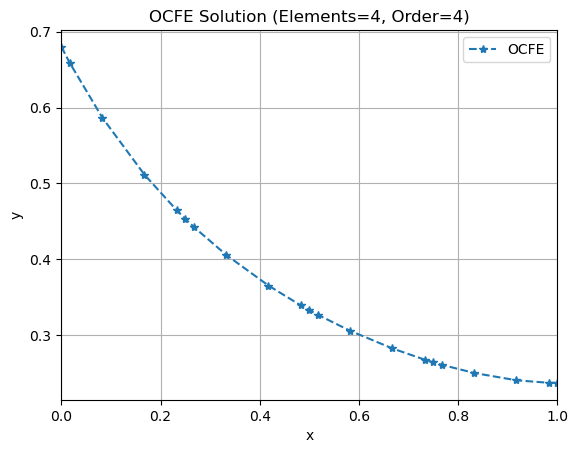

In [5]:
# User input

def main():
    n_elem = 4
    poly_order = 4
    # h = [0.25, 0.25, 0.2, 0.3]
    x, sol = ocfe_solver(n_elem=n_elem, poly_order=poly_order, h=None)
    print("x grid:", x)
    print("OCFE solution:", sol)
    plot_solution(x, sol, title=f'OCFE Solution (Elements={n_elem}, Order={poly_order})')

# if __name__ == "__main__":
#     main()
main()